# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [ ]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [515]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce

In [3]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.

stop_words = set(stopwords.words('english'))

In [5]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [7]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [11]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [12]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [14]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [15]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [16]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [17]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [18]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [19]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [22]:
# Load the CSV file as speeches.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [23]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [24]:
# Check for missing values.
speeches.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [25]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [26]:
# Review basic descriptive statistics.
speeches.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [27]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [28]:
# View the countries.
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [29]:
# View the author.
speeches['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Sentiment Label Lexicon**

In [31]:
# Load the CSV file as speeches.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

**2.3.c. Import Economic Indicators**

**Inflation**

In [419]:
# Load the CSV file as speeches.
inflation_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Historical data on UK inflation.xlsx')

# View the data.
inflation_uk_org.head()

Year        1        2        3        4        5        6        7  \
0  2025  0.02983  0.02836  0.02594      NaN      NaN      NaN      NaN   
1  2024  0.03981  0.03411  0.03228  0.02333  0.01990  0.01975  0.02234   
2  2023  0.10052  0.10416  0.10057  0.08658  0.08681  0.07950  0.06827   
3  2022  0.05456  0.06177  0.07023  0.09011  0.09083  0.09412  0.10101   
4  2021  0.00701  0.00414  0.00714  0.01526  0.02115  0.02514  0.02040   

         8        9       10       11       12   Annual  
0      NaN      NaN      NaN      NaN      NaN      NaN  
1  0.02216  0.01680  0.02281  0.02622  0.02503  0.02530  
2  0.06657  0.06652  0.04600  0.03941  0.03993  0.07303  
3  0.09870  0.10096  0.11052  0.10672  0.10528  0.09067  
4  0.03197  0.03080  0.04206  0.05130  0.05386  0.02588

In [421]:
# Drop column 'Annual'.
inflation_uk_org = inflation_uk_org.drop(columns=['Annual'])

# View the data.
inflation_uk_org.head()

Year        1        2        3        4        5        6        7  \
0  2025  0.02983  0.02836  0.02594      NaN      NaN      NaN      NaN   
1  2024  0.03981  0.03411  0.03228  0.02333  0.01990  0.01975  0.02234   
2  2023  0.10052  0.10416  0.10057  0.08658  0.08681  0.07950  0.06827   
3  2022  0.05456  0.06177  0.07023  0.09011  0.09083  0.09412  0.10101   
4  2021  0.00701  0.00414  0.00714  0.01526  0.02115  0.02514  0.02040   

         8        9       10       11       12  
0      NaN      NaN      NaN      NaN      NaN  
1  0.02216  0.01680  0.02281  0.02622  0.02503  
2  0.06657  0.06652  0.04600  0.03941  0.03993  
3  0.09870  0.10096  0.11052  0.10672  0.10528  
4  0.03197  0.03080  0.04206  0.05130  0.05386

In [423]:
# Transpose the DataFrame.
# The first row is treated as the header forthe DataFrame
inflation_uk_transposed = inflation_uk_org.melt(id_vars=["Year"], 
                        var_name="Month", 
                        value_name="Inflation Rate")

# Sort by year and then month.
inflation_uk_transposed = inflation_uk_transposed.sort_values(by=['Year', 'Month'])

# Reset the index and drop the old index.
inflation_uk_transposed.reset_index(drop=True, inplace=True)

# Create a new column 'Year-Month'
inflation_uk_transposed['year_month_object'] = inflation_uk_transposed['Year'].astype(str) + '-' \
                                        + inflation_uk_transposed['Month'].astype(str).str.zfill(2)

# Add a new column for year and month.
inflation_uk_transposed['year_month'] = pd.to_datetime(inflation_uk_transposed['year_month_object']).dt.to_period('M')

# Reorder the DataFrame
inflation_uk_transposed = inflation_uk_transposed[['Year', 'Month', 'year_month', 'Inflation Rate']]

# View the transformed DataFrame.
inflation_uk_transposed.head()

Year Month year_month  Inflation Rate
0  1989     1    1989-01         0.04897
1  1989     2    1989-02         0.04960
2  1989     3    1989-03         0.05011
3  1989     4    1989-04         0.05258
4  1989     5    1989-05         0.05328

In [385]:
# Save the data to a new Excel file
output_file_path = 'Historical data on UK inflation_transposed.xlsx'
inflation_uk_transposed.to_excel(output_file_path, index=False)

In [425]:
# View column types.
inflation_uk_transposed.dtypes

Year                  int64
Month                object
year_month        period[M]
Inflation Rate      float64
dtype: object

In [427]:
# Create a new DataFrame to be used in further analysis
inflation_uk = inflation_uk_transposed[['year_month', 'Inflation Rate']]

# View the DataFrame.
inflation_uk.head()

year_month  Inflation Rate
0    1989-01         0.04897
1    1989-02         0.04960
2    1989-03         0.05011
3    1989-04         0.05258
4    1989-05         0.05328

In [429]:
# View the rows in the DataFrame to ensure data ends in March 2025.
inflation_uk.tail(12)

year_month  Inflation Rate
432    2025-01         0.02983
433    2025-02         0.02836
434    2025-03         0.02594
435    2025-04             NaN
436    2025-05             NaN
437    2025-06             NaN
438    2025-07             NaN
439    2025-08             NaN
440    2025-09             NaN
441    2025-10             NaN
442    2025-11             NaN
443    2025-12             NaN

In [431]:
# Delete the last 9 rows from April 2025 onwards.
inflation_uk = inflation_uk.drop(inflation_uk.index[-9:])

# View the DataFrame.
inflation_uk.tail(12)

year_month  Inflation Rate
423    2024-04         0.02333
424    2024-05         0.01990
425    2024-06         0.01975
426    2024-07         0.02234
427    2024-08         0.02216
428    2024-09         0.01680
429    2024-10         0.02281
430    2024-11         0.02622
431    2024-12         0.02503
432    2025-01         0.02983
433    2025-02         0.02836
434    2025-03         0.02594

In [433]:
# Explore data set.
inflation_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   year_month      435 non-null    period[M]
 1   Inflation Rate  435 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 6.9 KB


In [435]:
# Check for missing values.
inflation_uk.isnull().sum()

year_month        0
Inflation Rate    0
dtype: int64

In [473]:
# View column types.
inflation_uk.dtypes

year_month        period[M]
Inflation Rate      float64
dtype: object

**Observation**: in April 2025 data is only available up to March 2025 so the last 9 months (April to December) of 2025 were removed from the dataset.

**Exchange Rates**

In [229]:
# Load the CSV file as speeches.
exchange_rates_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Exchange Rates.xlsx', header=2)

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling  
0                    192.4563              1.1941  
1                    190.0688              1.2039  
2                    193.1071              1.1921  
3                    194.3314              1.2079  
4                    195.8159              1.1998

In [231]:
# Add a new column to convert the date to datetime object.
exchange_rates_uk_org['date_formatted'] = pd.to_datetime(exchange_rates_uk_org['Date'], format="%d %b %y")

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling date_formatted  
0                    192.4563              1.1941     2025-03-31  
1                    190.0688              1.2039     2025-02-28  
2                    193.1071              1.1921     2025-01-31  
3                    194.3314              1.2079     2024-12-31  
4                    195.8159              1.1998     2024-11-30

In [233]:
# Extract year and month only
exchange_rates_uk_org['year_month_'] = pd.to_datetime(exchange_rates_uk_org['date_formatted']).dt.to_period('M')

# View the data.
exchange_rates_uk_org.head()

Date  Sterling (Jan 2005 = 100)  USD into Sterling  \
0  31 Mar 25                    84.8896             1.2911   
1  28 Feb 25                    86.8391             1.2545   
2  31 Jan 25                    85.9161             1.2348   
3  31 Dec 24                    84.5224             1.2647   
4  30 Nov 24                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling date_formatted year_month  
0                    192.4563              1.1941     2025-03-31    2025-03  
1                    190.0688              1.2039     2025-02-28    2025-02  
2                    193.1071              1.1921     2025-01-31    2025-01  
3                    194.3314              1.2079     2024-12-31    2024-12  
4                    195.8159              1.1998     2024-11-30    2024-11

In [437]:
# Create a new DataFrame to be used in further analysis
exchange_rates_uk = exchange_rates_uk_org[['year_month', 'Sterling (Jan 2005 = 100)', 'USD into Sterling',\
                                           'Japanese Yen into Sterling', 'Euro into Sterling']]

# View the DataFrame.
exchange_rates_uk.head()

year_month  Sterling (Jan 2005 = 100)  USD into Sterling  \
0    2025-03                    84.8896             1.2911   
1    2025-02                    86.8391             1.2545   
2    2025-01                    85.9161             1.2348   
3    2024-12                    84.5224             1.2647   
4    2024-11                    84.3938             1.2750   

   Japanese Yen into Sterling  Euro into Sterling  
0                    192.4563              1.1941  
1                    190.0688              1.2039  
2                    193.1071              1.1921  
3                    194.3314              1.2079  
4                    195.8159              1.1998

In [439]:
# Explore data set.
exchange_rates_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   year_month                  399 non-null    period[M]
 1   Sterling (Jan 2005 = 100)   399 non-null    float64  
 2   USD into Sterling           399 non-null    float64  
 3   Japanese Yen into Sterling  399 non-null    float64  
 4   Euro into Sterling          315 non-null    float64  
dtypes: float64(4), period[M](1)
memory usage: 15.7 KB


In [441]:
# Check for missing values.
exchange_rates_uk.isnull().sum()

year_month                     0
Sterling (Jan 2005 = 100)      0
USD into Sterling              0
Japanese Yen into Sterling     0
Euro into Sterling            84
dtype: int64

In [475]:
# View column types.
exchange_rates_uk.dtypes

year_month                    period[M]
Sterling (Jan 2005 = 100)       float64
USD into Sterling               float64
Japanese Yen into Sterling      float64
Euro into Sterling              float64
dtype: object

**Observation**: the Euro was introduced in January 1999, so there are no exchange rate value with the Euro prior to thatb date (84 entries).

**Unemployment rate (aged 16 and over, seasonally adjusted) in %**

In [479]:
# Load the CSV file as speeches.
unemployment_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Unemplyoment_series-250425.xlsx', header = 8)

# View the DataFrame.
unemployment_uk_org.head()

Date  Unemployment rate
0  1971 FEB                3.8
1  1971 MAR                3.9
2  1971 APR                4.0
3  1971 MAY                4.1
4  1971 JUN                4.1

In [481]:
# Function to convert the date format from e.g., "1971 JAN" to a period object for "1971-01"
def convert_date_to_period(date_str):
    # Split the year and month
    year, month_str = date_str.split()
    
    # Create a mapping of month names to month numbers
    month_mapping = {
        'JAN': '01',
        'FEB': '02',
        'MAR': '03',
        'APR': '04',
        'MAY': '05',
        'JUN': '06',
        'JUL': '07',
        'AUG': '08',
        'SEP': '09',
        'OCT': '10',
        'NOV': '11',
        'DEC': '12'
    }
    
    # Convert the month name to the corresponding number
    month = month_mapping.get(month_str.upper(), '00')  # Default to '00' if not found

    # Create a period object (specifying monthly frequency)
    return pd.Period(f"{year}-{month}", freq='M')
    
# Apply the conversion function to the 'Date' column
unemployment_uk_org['year_month'] = unemployment_uk_org['Date'].apply(convert_date_to_period)

# View the DataFrame
unemployment_uk_org.head()

Date  Unemployment rate year_month
0  1971 FEB                3.8    1971-02
1  1971 MAR                3.9    1971-03
2  1971 APR                4.0    1971-04
3  1971 MAY                4.1    1971-05
4  1971 JUN                4.1    1971-06

In [483]:
# View column types.
unemployment_uk_org.dtypes

Date                    object
Unemployment rate      float64
year_month           period[M]
dtype: object

In [485]:
# Create a new DataFrame to be used in further analysis
unemployment_uk = unemployment_uk_org[['year_month', 'Unemployment rate']]

# View the DataFrame.
unemployment_uk.head()

year_month  Unemployment rate
0    1971-02                3.8
1    1971-03                3.9
2    1971-04                4.0
3    1971-05                4.1
4    1971-06                4.1

In [487]:
# Explore data set.
unemployment_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   year_month         648 non-null    period[M]
 1   Unemployment rate  648 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 10.3 KB


In [489]:
# Check for missing values.
unemployment_uk.isnull().sum()

year_month           0
Unemployment rate    0
dtype: int64

In [491]:
# View column types.
unemployment_uk.dtypes

year_month           period[M]
Unemployment rate      float64
dtype: object

### 2.4. Date Transformation

In [104]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [105]:
# Change date format from 'object' to 'datetime64' and display in a new column.
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [406]:
# Add a new column for year and month.
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [408]:
# Add a new column for year only-
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [410]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year  \
0  1990-11-28    1990-11  1990   
1  1991-10-03    1991-10  1991   
2  1992-03-14    1992-03  1992   
3  1992-05-29    1992-05  1992   
4  1992-08-17    1992-08  1992   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  \
0  [would, doubt, argue, two, objectives, like, t...   
1  [today, wish, talk, real, interest, rates, mai...   
2  [welcome, opportunity, talk, prospects, banks,...   
3  [pleasure, opportunity, address, influential, ...   
4  [long, time, fan, sanders, delighted, particip...   

                                     text_lemmatised  \
0  [would, doubt, argue, two, objective, like, tr...   
1  [today, wish, talk, real, interest, rate, main...   
2  [welcome, opportunity, talk, prospect, bank, a...   
3  [pleasure, opportunity, address, influential, ...   
4  [long, time, fan, sander, delight, participate...   

                                 text_lemmatised_str  polarity_text  \
0  would doubt argue two objective like try cake ...       0.057930   
1  today wish talk real interest rate mainly hist...       0.094593   
2  welcome opportunity talk prospect bank austral...       0.092936   
3  pleasure opportunity address influential gathe...       0.076194   
4  long time fan sander delight participate tribu...       0.065280   

   subjectivity_text  
0           0.419487  
1           0.392546  
2           0.427280  
3           0.376906  
4           0.418965

In [493]:
# View column types.
speeches.dtypes

reference                      object
country                        object
date                           object
title                          object
author                         object
is_gov                          int64
text                           object
date_format            datetime64[ns]
year_month                  period[M]
year                            int32
text_cleaned                   object
text_tokenised                 object
text_lemmatised                object
text_lemmatised_str            object
polarity_text                 float64
subjectivity_text             float64
dtype: object

## 3. Exploratory Sentiment Analysis & Natural Language Processing (NLP)

### 3.1. Prepare the data

**3.1.a. Transformation to lowercase and removal of punctuation**
- Remove elements such as hashtags and urls
- Remove any special characters and punctuation
- Convert text to lower case
- Remove stopwords

In [113]:
# Apply the cleaning function
speeches['text_cleaned'] = speeches['text'].apply(preprocess_text)

# Review the result.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year  \
0  1990-11-28    1990-11  1990   
1  1991-10-03    1991-10  1991   
2  1992-03-14    1992-03  1992   
3  1992-05-29    1992-05  1992   
4  1992-08-17    1992-08  1992   

                                        text_cleaned  
0  would doubt argue two objectives like trying c...  
1  today wish talk real interest rates mainly his...  
2  welcome opportunity talk prospects banks austr...  
3  pleasure opportunity address influential gathe...  
4  long time fan sanders delighted participating ...

**3.1.b. Tokenisation of the data**<br>
Split the cleaned text into individual words, so that text can be analysed at word level.

In [115]:
# Apply the cleaning function
speeches['text_tokenised'] = speeches['text_cleaned'].apply(word_tokenize)

# Review the result.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year  \
0  1990-11-28    1990-11  1990   
1  1991-10-03    1991-10  1991   
2  1992-03-14    1992-03  1992   
3  1992-05-29    1992-05  1992   
4  1992-08-17    1992-08  1992   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  
0  [would, doubt, argue, two, objectives, like, t...  
1  [today, wish, talk, real, interest, rates, mai...  
2  [welcome, opportunity, talk, prospects, banks,...  
3  [pleasure, opportunity, address, influential, ...  
4  [long, time, fan, sanders, delighted, particip...

**3.1.c. Lemmatisation of the data**<br>
Reduce words to its base or dictionary form (the lemma).

In [117]:
# Apply the cleaning function
speeches['text_lemmatised'] = speeches['text_tokenised'].apply(lemmatize_tokens)

# Review the result.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year  \
0  1990-11-28    1990-11  1990   
1  1991-10-03    1991-10  1991   
2  1992-03-14    1992-03  1992   
3  1992-05-29    1992-05  1992   
4  1992-08-17    1992-08  1992   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  \
0  [would, doubt, argue, two, objectives, like, t...   
1  [today, wish, talk, real, interest, rates, mai...   
2  [welcome, opportunity, talk, prospects, banks,...   
3  [pleasure, opportunity, address, influential, ...   
4  [long, time, fan, sanders, delighted, particip...   

                                     text_lemmatised  
0  [would, doubt, argue, two, objective, like, tr...  
1  [today, wish, talk, real, interest, rate, main...  
2  [welcome, opportunity, talk, prospect, bank, a...  
3  [pleasure, opportunity, address, influential, ...  
4  [long, time, fan, sander, delight, participate...

### 3.2. View data in a wordclouds 

In [119]:
# Group 'review_lemmatised' to show the count per review.
speeches['text_lemmatised_str'] = speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
speeches_top_words = speeches.groupby('text_lemmatised_str').size().reset_index(name='count')

# Sort the counts descending.
speeches_top_words_sorted = speeches_top_words.sort_values(by='count', ascending=False)
top_15_words = speeches_top_words_sorted.head(15)

# View the top 15 reviews by count.
top_15_words

text_lemmatised_str  count
6627  thank invite speak today know would welcome in...      3
5954  several quarter higher expected growth late eu...      2
90    almost certainly important economic developmen...      2
1563  find speaking london school economics mileston...      2
2359  governor bank canada good afternoon tiff pleas...      2
4555  monetary policy committee accustom describe pl...      2
6139  statement haruhiko kuroda governor bank japan ...      2
3284  honour launch productivity alberta luncheon se...      2
6144  statement haruhiko kuroda governor bank japan ...      2
6148  statement haruhiko kuroda governor bank japan ...      2
6136  statement haruhiko kuroda governor bank japan ...      2
6635  thank invite speak today remark focus near ter...      2
6301  tend reach payment method accustom use form ha...      2
665   covid 19 pandemic severely disruptive economic...      2
285   bank england relationship financial market par...      2

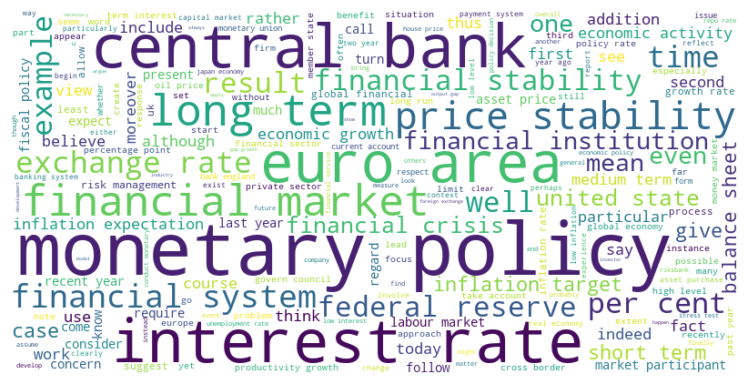

In [120]:
# Convert tokens into a single string.
speeches_text = ' '.join(speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

In [121]:
# Generate a list of top words
word_list = speeches_text.split()  # Split the text into individual words
word_counts = Counter(word_list)  # Count occurrences of each word

# Get the top N words
top_n = 20  # Change this to the number of top words you want to see
top_words = word_counts.most_common(top_n)

# Display the top words as a list
print("Top words:")
for word, count in top_words:
    print(f"{word}: {count}")

Top words:
bank: 157269
policy: 129403
financial: 123310
rate: 118233
not: 117698
market: 116494
inflation: 89303
price: 86609
monetary: 85134
economy: 80934
risk: 79735
year: 71950
would: 67178
also: 66449
economic: 64554
growth: 64011
increase: 57563
time: 53691
term: 52117
interest: 49262


In [122]:
%%time
# Demo: Frequency distribution review of a single speech.

# Tokenise the text data.
stop_words=set(stopwords.words('english'))
filtered_text = []

# Example speech using iloc to reference (Hint: Can be used in loops if required).
tokenized_word = word_tokenize(boe_speeches.iloc[0,6])

# Filter the tokenised words.
for each_word in tokenized_word:
    if each_word.lower() not in stop_words and each_word.isalpha():
        filtered_text.append(each_word.lower())

# Display the filtered list.
#print('Tokenised list without stop words: {}'.format(filtered_text))

# Create a frequency distribution object.
freq_dist_of_words = FreqDist(filtered_text)

# Show the five most common elements in the data set.
freq_dist_of_words.most_common(10)

NameError: name 'boe_speeches' is not defined

In [123]:
# Get the set of stop words
stop_words = set(stopwords.words('english'))

# Dictionary to store frequency distributions for each speech
all_freq_dists = {}

# Loop over each speech
for i in range(len(boe_speeches)):
    # Tokenize the text data for each speech
    filtered_text = []
    tokenized_word = word_tokenize(boe_speeches.iloc[i, 6])  # Adjust the column index as necessary

    # Filter the tokenized words
    for each_word in tokenized_word:
        if each_word.lower() not in stop_words and each_word.isalpha():
            filtered_text.append(each_word.lower())

    # Create a frequency distribution object for each speech
    freq_dist_of_words = FreqDist(filtered_text)
    
    # Store the frequency distribution in a dictionary
    all_freq_dists[i] = freq_dist_of_words

# Example: Display the five most common elements of the first speech
print(all_freq_dists[0].most_common(5))  # Change 0 to another index for other speeches

NameError: name 'boe_speeches' is not defined

In [ ]:
# Initialize a list to hold frequency distributions
freq_dists = {}

# Create frequency distributions for each speech
for index in range(len(boe_speeches)):
    speech_text = boe_speeches.iloc[index]['text']  # Adjust the column name as necessary
    # Tokenize the speech and filter stop words
    stop_words = set(stopwords.words('english'))
    tokenized_word = word_tokenize(speech_text)
    filtered_text = [word.lower() for word in tokenized_word if word.lower() not in stop_words and word.isalpha()]
    
    # Create a frequency distribution object
    freq_dists[index] = FreqDist(filtered_text)

# Now filter speeches that contain "inflation" in the top 5 words
specific_word = "inflation"
filtered_indices = []

for idx, freq_dist in freq_dists.items():
    top_words = [word for word, _ in freq_dist.most_common(5)]
    if specific_word in top_words:
        filtered_indices.append(idx)

# Now filter the sentiment DataFrame to show only the speeches that have "inflation" in the top 5
filtered_speeches = boe_speeches.iloc[filtered_indices]

# Calculate sentiment scores for filtered speeches
filtered_sentiment_results = {}

for idx in filtered_indices:
    speech_text = boe_speeches.iloc[idx]['text']
    sentiment_score = calculate_sentiment_score(speech_text, positive_words, negative_words)
    filtered_sentiment_results[idx] = sentiment_score

# Display the filtered speeches and their sentiment scores
for idx in filtered_indices:
    print(f"Speech Index: {idx}, Speech Text: {boe_speeches.iloc[idx]['text']}")
    print(f"Sentiment Score: {filtered_sentiment_results[idx]}")
    print("----")

### 3.3. Sentiment Analysis using VADER Sentiment Intensity Analyzer for BoE speeches

In [499]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  polarity_text  \
4961  thank chairman actually pleased opportunity re...       0.050647   
4962  great pleasure beautiful city bruges honour op...       0.062814   
4963  industry suffer volatility british economy pas...       0.045922   
4964  topic evening use forecast economic policy mak...       0.041968   
4965  six year ago week sterling leave exchange rate...       0.048576   

      subjectivity_text  
4961           0.417626  
4962           0.351627  
4963           0.376753  
4964           0.462368  
4965           0.389893

In [501]:
# View column types.
boe_speeches.dtypes

reference                      object
country                        object
date                           object
title                          object
author                         object
is_gov                          int64
text                           object
date_format            datetime64[ns]
year_month                  period[M]
year                            int32
text_cleaned                   object
text_tokenised                 object
text_lemmatised                object
text_lemmatised_str            object
polarity_text                 float64
subjectivity_text             float64
dtype: object

VADER categorises reviews as positive, negative, or neutral sentiments based on its emotional tone.

In [529]:
# Apply sentiment analysis to the columns using the lemmatised data converted into strings.
boe_speeches['sentiment_score'] = boe_speeches['text_lemmatised'].apply(analyse_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year                                       text_cleaned  \
4961    1998-09  1998  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  great pleasure beautiful city bruges honoured ...   
4963    1998-10  1998  industries suffered volatility british economy...   
4964    1998-11  1998  topic evening use forecasts economic policy ma...   
4965    1998-11  1998  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  polarity_text  \
4961  thank chairman actually pleased opportunity re...       0.050647   
4962  great pleasure beautiful city bruges honour op...       0.062814   
4963  industry suffer volatility british economy pas...       0.045922   
4964  topic evening use forecast economic policy mak...       0.041968   
4965  six year ago week sterling leave exchange rate...       0.048576   

      subjectivity_text                                    sentiment_score  
4961           0.417626  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...  
4962           0.351627  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...  
4963           0.376753  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...  
4964           0.462368  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...  
4965           0.389893  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...

In [530]:
# Extract individual sentiment scores for speeches.
boe_speeches['text_neg'] = boe_speeches['sentiment_score'].apply(lambda x: x['neg'])
boe_speeches['text_neu'] = boe_speeches['sentiment_score'].apply(lambda x: x['neu'])
boe_speeches['text_pos'] = boe_speeches['sentiment_score'].apply(lambda x: x['pos'])
boe_speeches['text_compound'] = boe_speeches['sentiment_score'].apply(lambda x: x['compound'])

In [531]:
# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                     text_tokenised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industries, suffered, volatility, british, ec...   
4964    1998-11  1998  ...  [topic, evening, use, forecasts, economic, pol...   
4965    1998-11  1998  ...  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str polarity_text  \
4961  thank chairman actually pleased opportunity re...      0.050647   
4962  great pleasure beautiful city bruges honour op...      0.062814   
4963  industry suffer volatility british economy pas...      0.045922   
4964  topic evening use forecast economic policy mak...      0.041968   
4965  six year ago week sterling leave exchange rate...      0.048576   

      subjectivity_text                                    sentiment_score  \
4961           0.417626  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962           0.351627  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963           0.376753  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964           0.462368  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965           0.389893  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

     text_neg  text_neu  text_pos  text_compound  
4961    0.143     0.700     0.157         0.9898  
4962    0.094     0.684     0.222         0.9998  
4963    0.106     0.732     0.161         0.9969  
4964    0.078     0.784     0.139         0.9993  
4965    0.093     0.783     0.124         0.9984  

[5 rows x 21 columns]

In [532]:
# VADER Sentiment Labelling
def label_vader(c, thr=0.05):
    if c >  thr:
        return 'Positive'
    if c < -thr:
        return 'Negative'
    return 'Neutral'

# Apply the sentiment labels to speeches
boe_speeches['Sentiment Label (VADER)'] = boe_speeches['text_compound'].apply(label_vader)

# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str polarity_text  \
4961  thank chairman actually pleased opportunity re...      0.050647   
4962  great pleasure beautiful city bruges honour op...      0.062814   
4963  industry suffer volatility british economy pas...      0.045922   
4964  topic evening use forecast economic policy mak...      0.041968   
4965  six year ago week sterling leave exchange rate...      0.048576   

     subjectivity_text                                    sentiment_score  \
4961          0.417626  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962          0.351627  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963          0.376753  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964          0.462368  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965          0.389893  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

      text_neg text_neu  text_pos  text_compound  Sentiment Label (VADER)  
4961     0.143    0.700     0.157         0.9898                 Positive  
4962     0.094    0.684     0.222         0.9998                 Positive  
4963     0.106    0.732     0.161         0.9969                 Positive  
4964     0.078    0.784     0.139         0.9993                 Positive  
4965     0.093    0.783     0.124         0.9984                 Positive  

[5 rows x 22 columns]

In [533]:
# Apply the sentiment labels to speeches
# boe_speeches['speech_sentiment'] = boe_speeches['text_compound'].apply(get_sentiment_label)

# View the DataFrame.
# boe_speeches.head()

In [534]:
# Average VADER Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['text_compound', 'text_pos', 'text_neg', 'text_neu']]
      .mean()
      .round(3)           
                  
)

print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


text_compound  text_pos  text_neg  text_neu
year                                             
1998          0.997     0.161     0.107     0.732
1999          0.932     0.175     0.098     0.727
2000          0.943     0.201     0.089     0.710
2001          0.941     0.179     0.104     0.717
2002          0.932     0.189     0.104     0.707
2003          0.789     0.181     0.100     0.718
2004          0.803     0.176     0.091     0.733
2005          0.998     0.170     0.092     0.738
2006          0.876     0.175     0.098     0.727
2007          0.885     0.178     0.096     0.727
2008          0.906     0.171     0.109     0.719
2009          0.778     0.182     0.121     0.697
2010          0.781     0.170     0.114     0.716
2011          0.660     0.166     0.118     0.716
2012          0.542     0.169     0.123     0.709
2013          0.970     0.182     0.101     0.717
2014          0.737     0.178     0.115     0.707
2015          0.792     0.178     0.103     0.719
2016          0.762     0.181     0.107     0.712
2017          0.680     0.180     0.100     0.720
2018          0.954     0.181     0.092     0.727
2019          0.776     0.180     0.097     0.723
2020          0.481     0.165     0.106     0.729
2021          0.886     0.164     0.088     0.748
2022          0.793     0.164     0.092     0.744

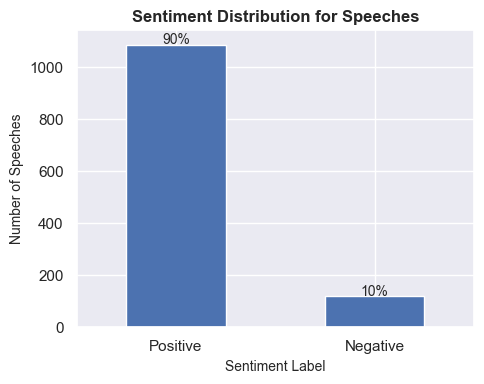

In [535]:
# Plot the sentiments distribution for review.
sentiment_labels = boe_speeches['Sentiment Label (VADER)']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar') # color=['#339848', '#482173', '#557cbb'

# Add labels.
plt.title('Sentiment Distribution for Speeches', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Speeches', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
plt.savefig('Fig_Sentiment_Speeches.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

### 3.4. Review Polarity and Subjectivity using TextBlob

In [536]:
# Populate a new column with polarity scores for each comment.
boe_speeches['polarity_text'] = boe_speeches['text_lemmatised_str'].apply(generate_polarity)

# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str polarity_text  \
4961  thank chairman actually pleased opportunity re...      0.050647   
4962  great pleasure beautiful city bruges honour op...      0.062814   
4963  industry suffer volatility british economy pas...      0.045922   
4964  topic evening use forecast economic policy mak...      0.041968   
4965  six year ago week sterling leave exchange rate...      0.048576   

     subjectivity_text                                    sentiment_score  \
4961          0.417626  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962          0.351627  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963          0.376753  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964          0.462368  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965          0.389893  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

      text_neg text_neu  text_pos  text_compound  Sentiment Label (VADER)  
4961     0.143    0.700     0.157         0.9898                 Positive  
4962     0.094    0.684     0.222         0.9998                 Positive  
4963     0.106    0.732     0.161         0.9969                 Positive  
4964     0.078    0.784     0.139         0.9993                 Positive  
4965     0.093    0.783     0.124         0.9984                 Positive  

[5 rows x 22 columns]

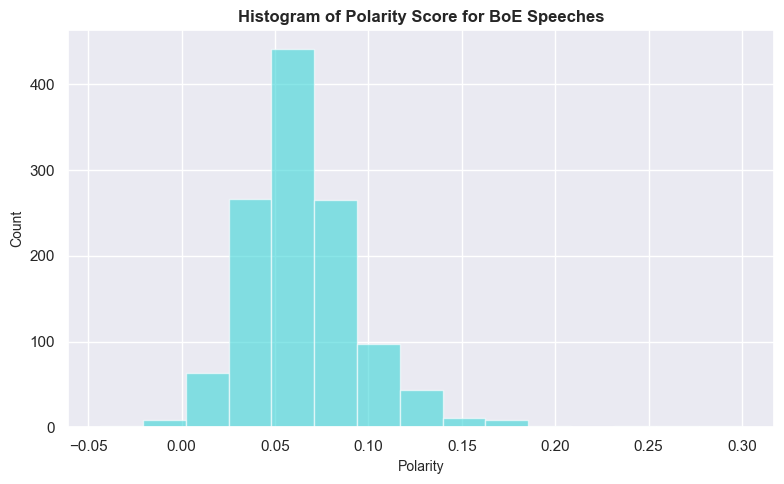

In [537]:
# Plot a histogram of the polarity score for reviews.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['polarity_text'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Polarity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [538]:
# Populate a new column with polarity scores for each comment.
boe_speeches['subjectivity_text'] = boe_speeches['text_lemmatised_str'].apply(generate_subjectivity)

# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str polarity_text  \
4961  thank chairman actually pleased opportunity re...      0.050647   
4962  great pleasure beautiful city bruges honour op...      0.062814   
4963  industry suffer volatility british economy pas...      0.045922   
4964  topic evening use forecast economic policy mak...      0.041968   
4965  six year ago week sterling leave exchange rate...      0.048576   

     subjectivity_text                                    sentiment_score  \
4961          0.417626  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962          0.351627  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963          0.376753  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964          0.462368  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965          0.389893  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

      text_neg text_neu  text_pos  text_compound  Sentiment Label (VADER)  
4961     0.143    0.700     0.157         0.9898                 Positive  
4962     0.094    0.684     0.222         0.9998                 Positive  
4963     0.106    0.732     0.161         0.9969                 Positive  
4964     0.078    0.784     0.139         0.9993                 Positive  
4965     0.093    0.783     0.124         0.9984                 Positive  

[5 rows x 22 columns]

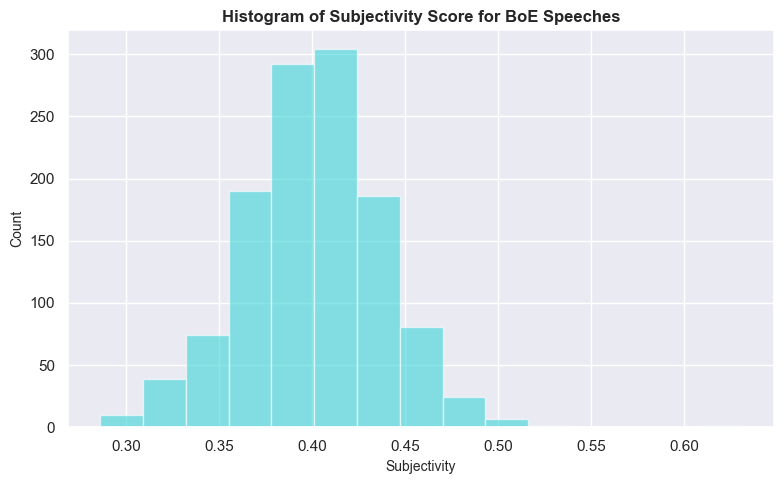

In [539]:
# Plot a histogram of the polarity score for summary.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['subjectivity_text'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Subjectivity', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Subjectivity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.5. Sentiment Analysis with BoE Sentiment Wordlist for BoE speeches

In [542]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()
categories = [
     'Negative',
     'Positive',
     'Uncertainty',
     'Litigious',
     'Strong',
     'Weak',
     'Constraining',
 ]
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, "Word"].str.lower())
    for cat in categories
}

def lexicon_counts(text: str) -> pd.Series:
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return pd.Series({cat: sum(t in word_sets[cat] for t in tokens) for cat in categories})

boe_speeches = pd.concat(
    [boe_speeches, boe_speeches["text"].apply(lexicon_counts)], axis=1
 )
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... text_pos text_compound Sentiment Label (VADER)  \
4961    1998-09  1998  ...    0.157        0.9898                Positive   
4962    1998-10  1998  ...    0.222        0.9998                Positive   
4963    1998-10  1998  ...    0.161        0.9969                Positive   
4964    1998-11  1998  ...    0.139        0.9993                Positive   
4965    1998-11  1998  ...    0.124        0.9984                Positive   

     Negative  Positive  Uncertainty Litigious  Strong  Weak  Constraining  
4961       63        39           24         3      20    16             2  
4962       87        82           52         6      39    30            16  
4963       61        33           49         2      11    17             5  
4964       78        43           92        11      31    42            15  
4965      102        46          119        22      20    49            12  

[5 rows x 29 columns]

In [543]:
# Calculate the sentiment score by subtracting the negative score from the positive score
boe_speeches['sentiment_score_lexicon'] = boe_speeches['Positive'] - boe_speeches['Negative'] 

# View the DataFrame.
boe_speeches.head()

reference         country        date  \
4961  r980915a_BOE  united kingdom  1998-09-15   
4962  r981021b_BOE  united kingdom  1998-10-21   
4963  r981021a_BOE  united kingdom  1998-10-21   
4964  r981101a_BOE  united kingdom  1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       0   
4962                                  Britain in Europe   george       0   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... text_compound Sentiment Label (VADER) Negative  \
4961    1998-09  1998  ...        0.9898                Positive       63   
4962    1998-10  1998  ...        0.9998                Positive       87   
4963    1998-10  1998  ...        0.9969                Positive       61   
4964    1998-11  1998  ...        0.9993                Positive       78   
4965    1998-11  1998  ...        0.9984                Positive      102   

     Positive  Uncertainty  Litigious Strong  Weak  Constraining  \
4961       39           24          3     20    16             2   
4962       82           52          6     39    30            16   
4963       33           49          2     11    17             5   
4964       43           92         11     31    42            15   
4965       46          119         22     20    49            12   

      sentiment_score_lexicon  
4961                      -24  
4962                       -5  
4963                      -28  
4964                      -35  
4965                      -56  

[5 rows x 30 columns]

### 3.6. Plot the data over time

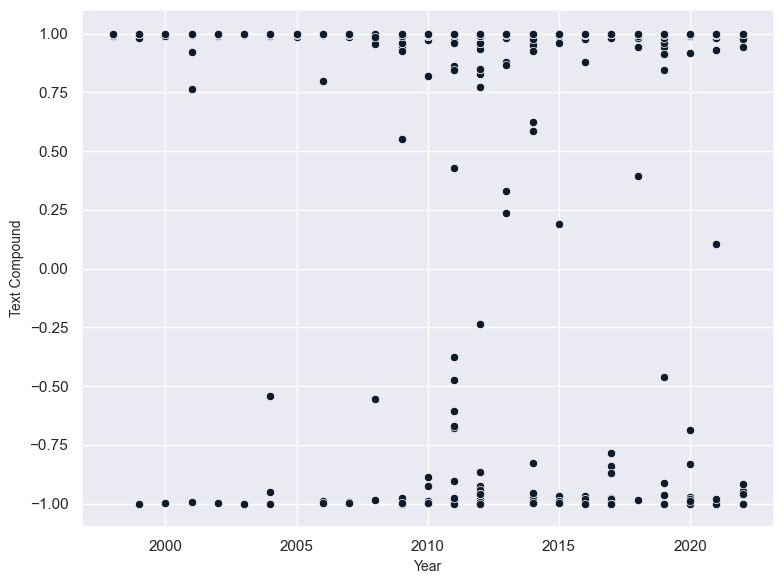

In [545]:
# Scatterplot for sentiment scores over time.
generate_scatterplot(boe_speeches, x_axis='year', y_axis='text_compound', title=None, hue=None, save_path=None)

## 5. Exploratory Analysis for Correlation with Economic Indicators

In [546]:
# List of DataFrames to merge
dataframes_to_merge = [unemployment_uk, exchange_rates_uk, inflation_uk]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

reference         country        date  \
0  r980915a_BOE  united kingdom  1998-09-15   
1  r981021b_BOE  united kingdom  1998-10-21   
2  r981021a_BOE  united kingdom  1998-10-21   
3  r981101a_BOE  united kingdom  1998-11-01   
4  r981101b_BOE  united kingdom  1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       0   
1                                  Britain in Europe   george       0   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ... Strong Weak Constraining sentiment_score_lexicon  \
0  1998  ...     20   16            2                     -24   
1  1998  ...     39   30           16                      -5   
2  1998  ...     11   17            5                     -28   
3  1998  ...     31   42           15                     -35   
4  1998  ...     20   49           12                     -56   

   Unemployment rate  Sterling (Jan 2005 = 100) USD into Sterling  \
0                6.2                    99.4485            1.6822   
1                6.2                    97.2314            1.6952   
2                6.2                    97.2314            1.6952   
3                6.1                    97.0023            1.6620   
4                6.1                    97.0023            1.6620   

   Japanese Yen into Sterling  Euro into Sterling  Inflation Rate  
0                    226.1941                 NaN         0.01410  
1                    205.0187                 NaN         0.01365  
2                    205.0187                 NaN         0.01365  
3                    199.9839                 NaN         0.01349  
4                    199.9839                 NaN         0.01349  

[5 rows x 36 columns]

In [547]:
# Check for missing values.
boe_speeches_indicators.isnull().sum()

reference                     0
country                       0
date                          0
title                         0
author                        0
is_gov                        0
text                          0
date_format                   0
year_month                    0
year                          0
text_cleaned                  0
text_tokenised                0
text_lemmatised               0
text_lemmatised_str           0
polarity_text                 0
subjectivity_text             0
sentiment_score               0
text_neg                      0
text_neu                      0
text_pos                      0
text_compound                 0
Sentiment Label (VADER)       0
Negative                      0
Positive                      0
Uncertainty                   0
Litigious                     0
Strong                        0
Weak                          0
Constraining                  0
sentiment_score_lexicon       0
Unemployment rate             0
Sterling

In [548]:
# Explore the DataFrame.
boe_speeches_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   reference                   1209 non-null   object        
 1   country                     1209 non-null   object        
 2   date                        1209 non-null   object        
 3   title                       1209 non-null   object        
 4   author                      1209 non-null   object        
 5   is_gov                      1209 non-null   int64         
 6   text                        1209 non-null   object        
 7   date_format                 1209 non-null   datetime64[ns]
 8   year_month                  1209 non-null   period[M]     
 9   year                        1209 non-null   int32         
 10  text_cleaned                1209 non-null   object        
 11  text_tokenised              1209 non-null   object      

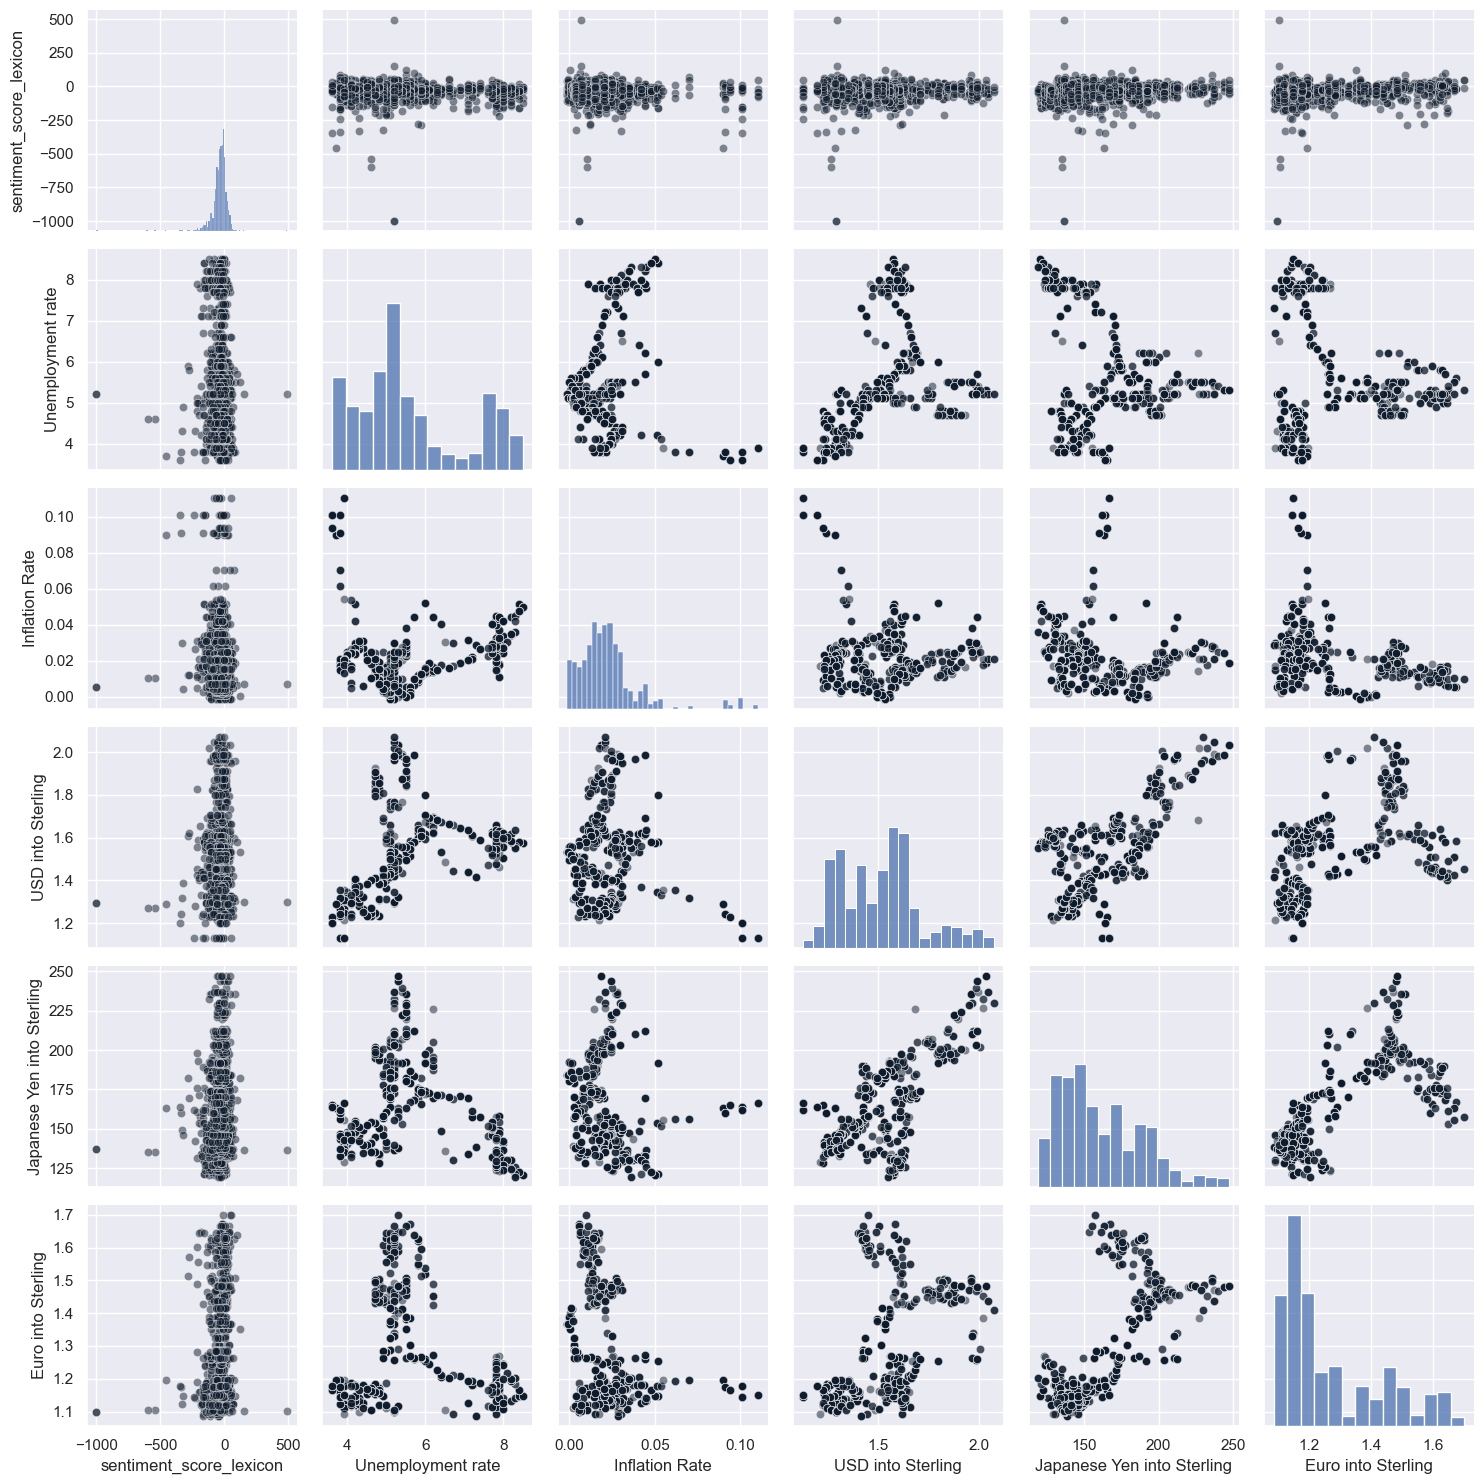

In [584]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_lexicon = ['sentiment_score_lexicon', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_lexicon], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [598]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_lexicon = boe_speeches_indicators[columns_sentiment_lexicon].corr()

# Display the correlation matrix
correlation_matrix_lexicon

sentiment_score_lexicon  Unemployment rate  \
sentiment_score_lexicon                    1.000000          -0.081018   
Unemployment rate                         -0.081018           1.000000   
Inflation Rate                            -0.078017           0.067503   
USD into Sterling                          0.053008           0.433865   
Japanese Yen into Sterling                 0.101874          -0.243363   
Euro into Sterling                         0.113039          -0.094911   

                            Inflation Rate  USD into Sterling  \
sentiment_score_lexicon          -0.078017           0.053008   
Unemployment rate                 0.067503           0.433865   
Inflation Rate                    1.000000          -0.118608   
USD into Sterling                -0.118608           1.000000   
Japanese Yen into Sterling       -0.177402           0.660607   
Euro into Sterling               -0.331445           0.467030   

                            Japanese Yen into Sterling  Euro into Sterling  
sentiment_score_lexicon                       0.101874            0.113039  
Unemployment rate                            -0.243363           -0.094911  
Inflation Rate                               -0.177402           -0.331445  
USD into Sterling                             0.660607            0.467030  
Japanese Yen into Sterling                    1.000000            0.701887  
Euro into Sterling                            0.701887            1.000000

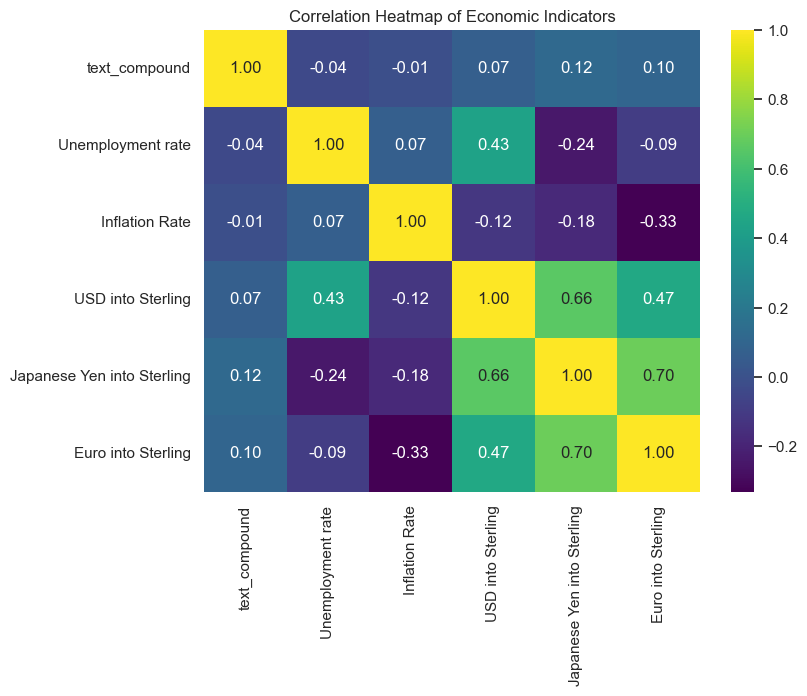

In [600]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

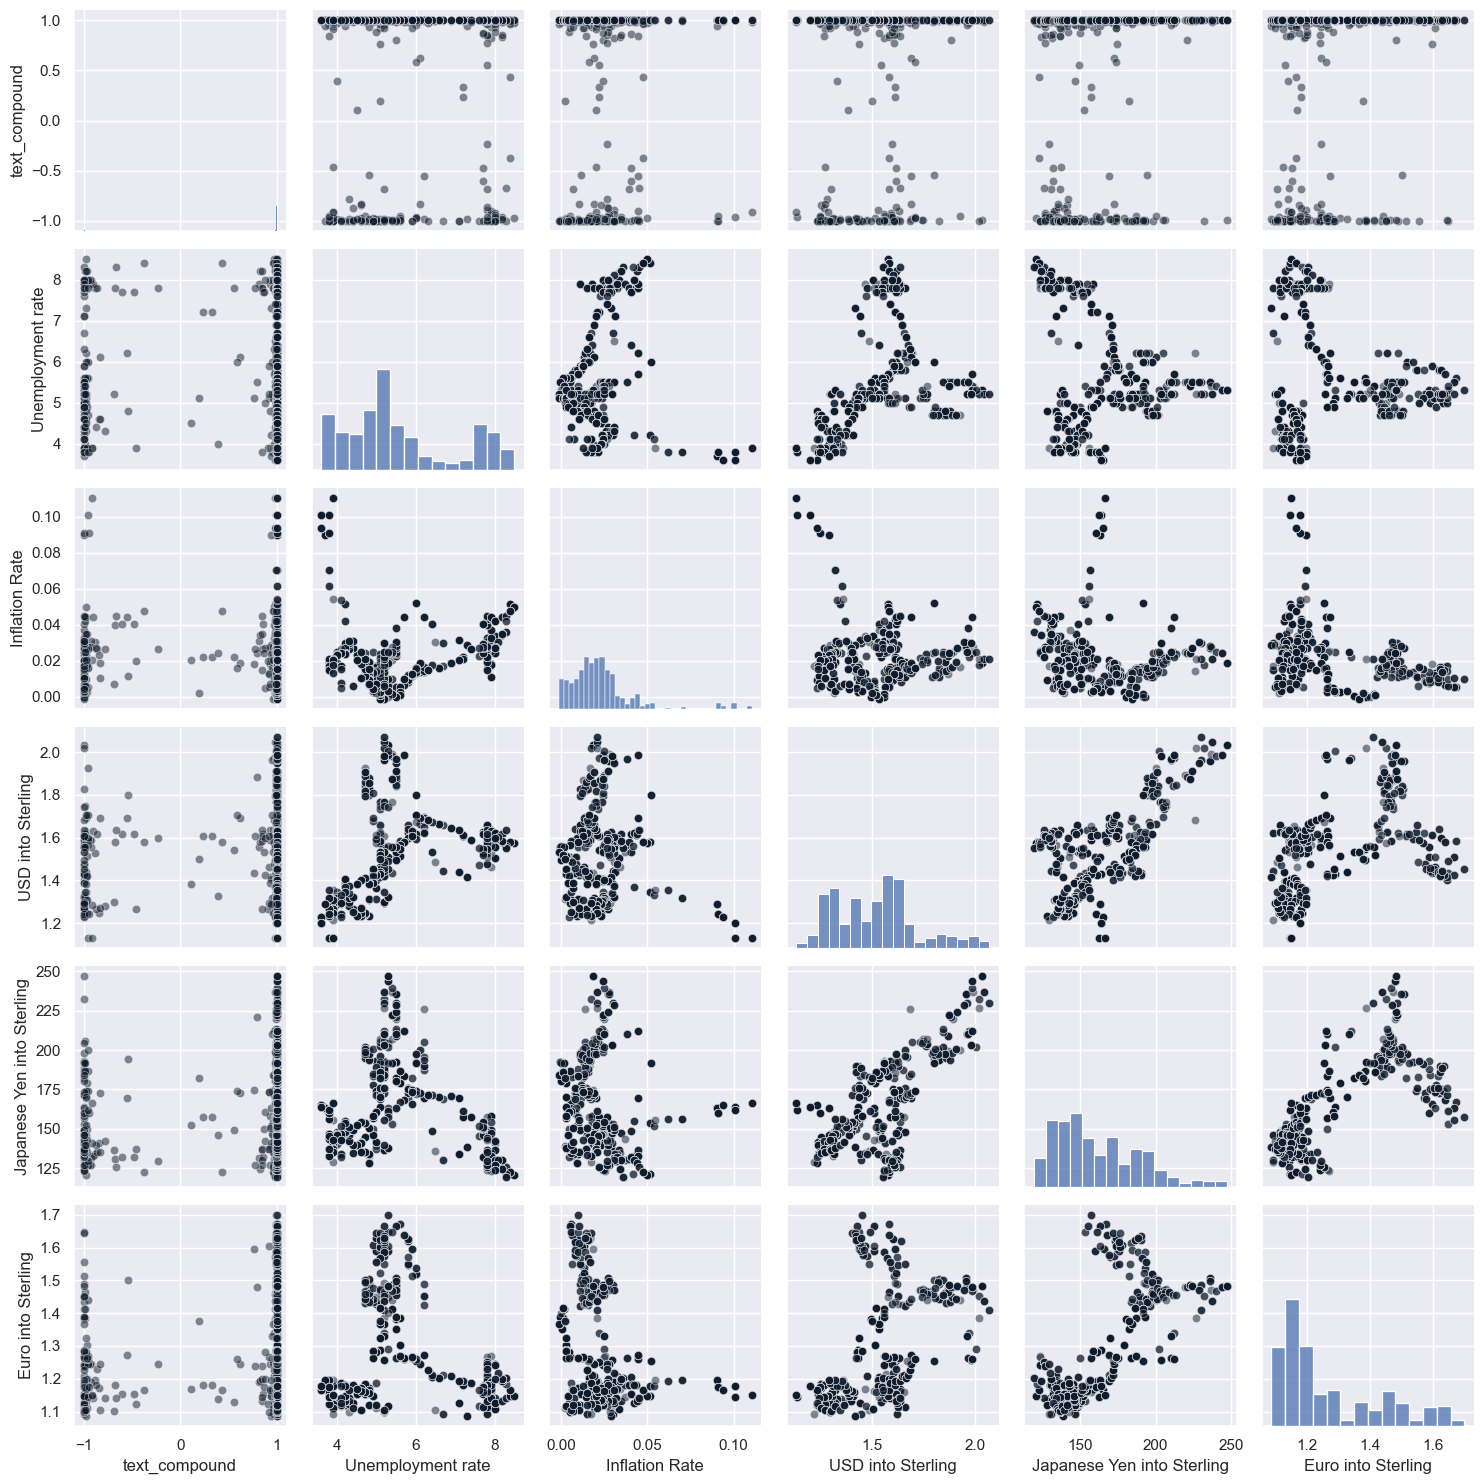

In [594]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_compound = ['text_compound', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_vader_compound], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [602]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader = boe_speeches_indicators[columns_vader_compound].corr()

# Display the correlation matrix
correlation_matrix_vader

text_compound  Unemployment rate  Inflation Rate  \
text_compound                    1.000000          -0.038064       -0.009871   
Unemployment rate               -0.038064           1.000000        0.067503   
Inflation Rate                  -0.009871           0.067503        1.000000   
USD into Sterling                0.068449           0.433865       -0.118608   
Japanese Yen into Sterling       0.119718          -0.243363       -0.177402   
Euro into Sterling               0.096675          -0.094911       -0.331445   

                            USD into Sterling  Japanese Yen into Sterling  \
text_compound                        0.068449                    0.119718   
Unemployment rate                    0.433865                   -0.243363   
Inflation Rate                      -0.118608                   -0.177402   
USD into Sterling                    1.000000                    0.660607   
Japanese Yen into Sterling           0.660607                    1.000000   
Euro into Sterling                   0.467030                    0.701887   

                            Euro into Sterling  
text_compound                         0.096675  
Unemployment rate                    -0.094911  
Inflation Rate                       -0.331445  
USD into Sterling                     0.467030  
Japanese Yen into Sterling            0.701887  
Euro into Sterling                    1.000000

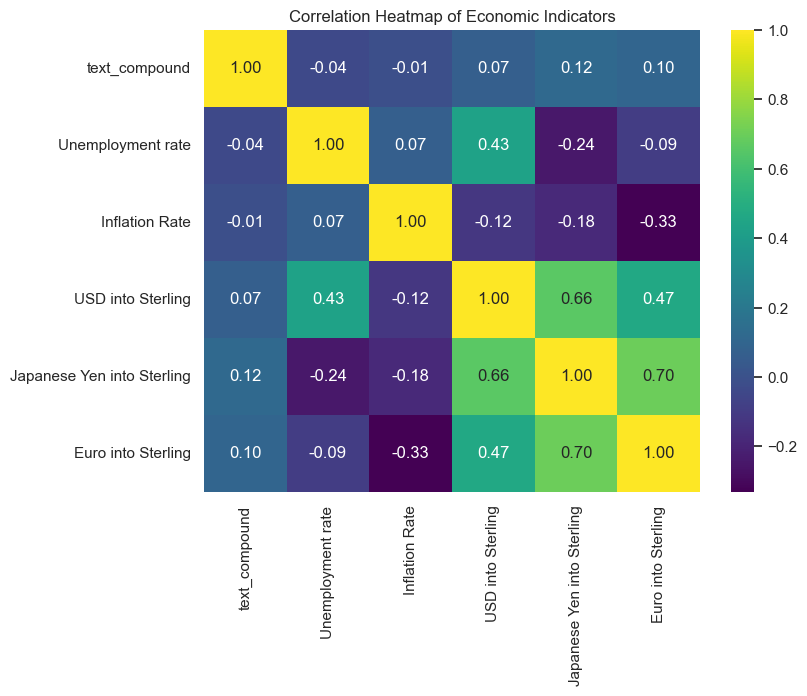

In [604]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

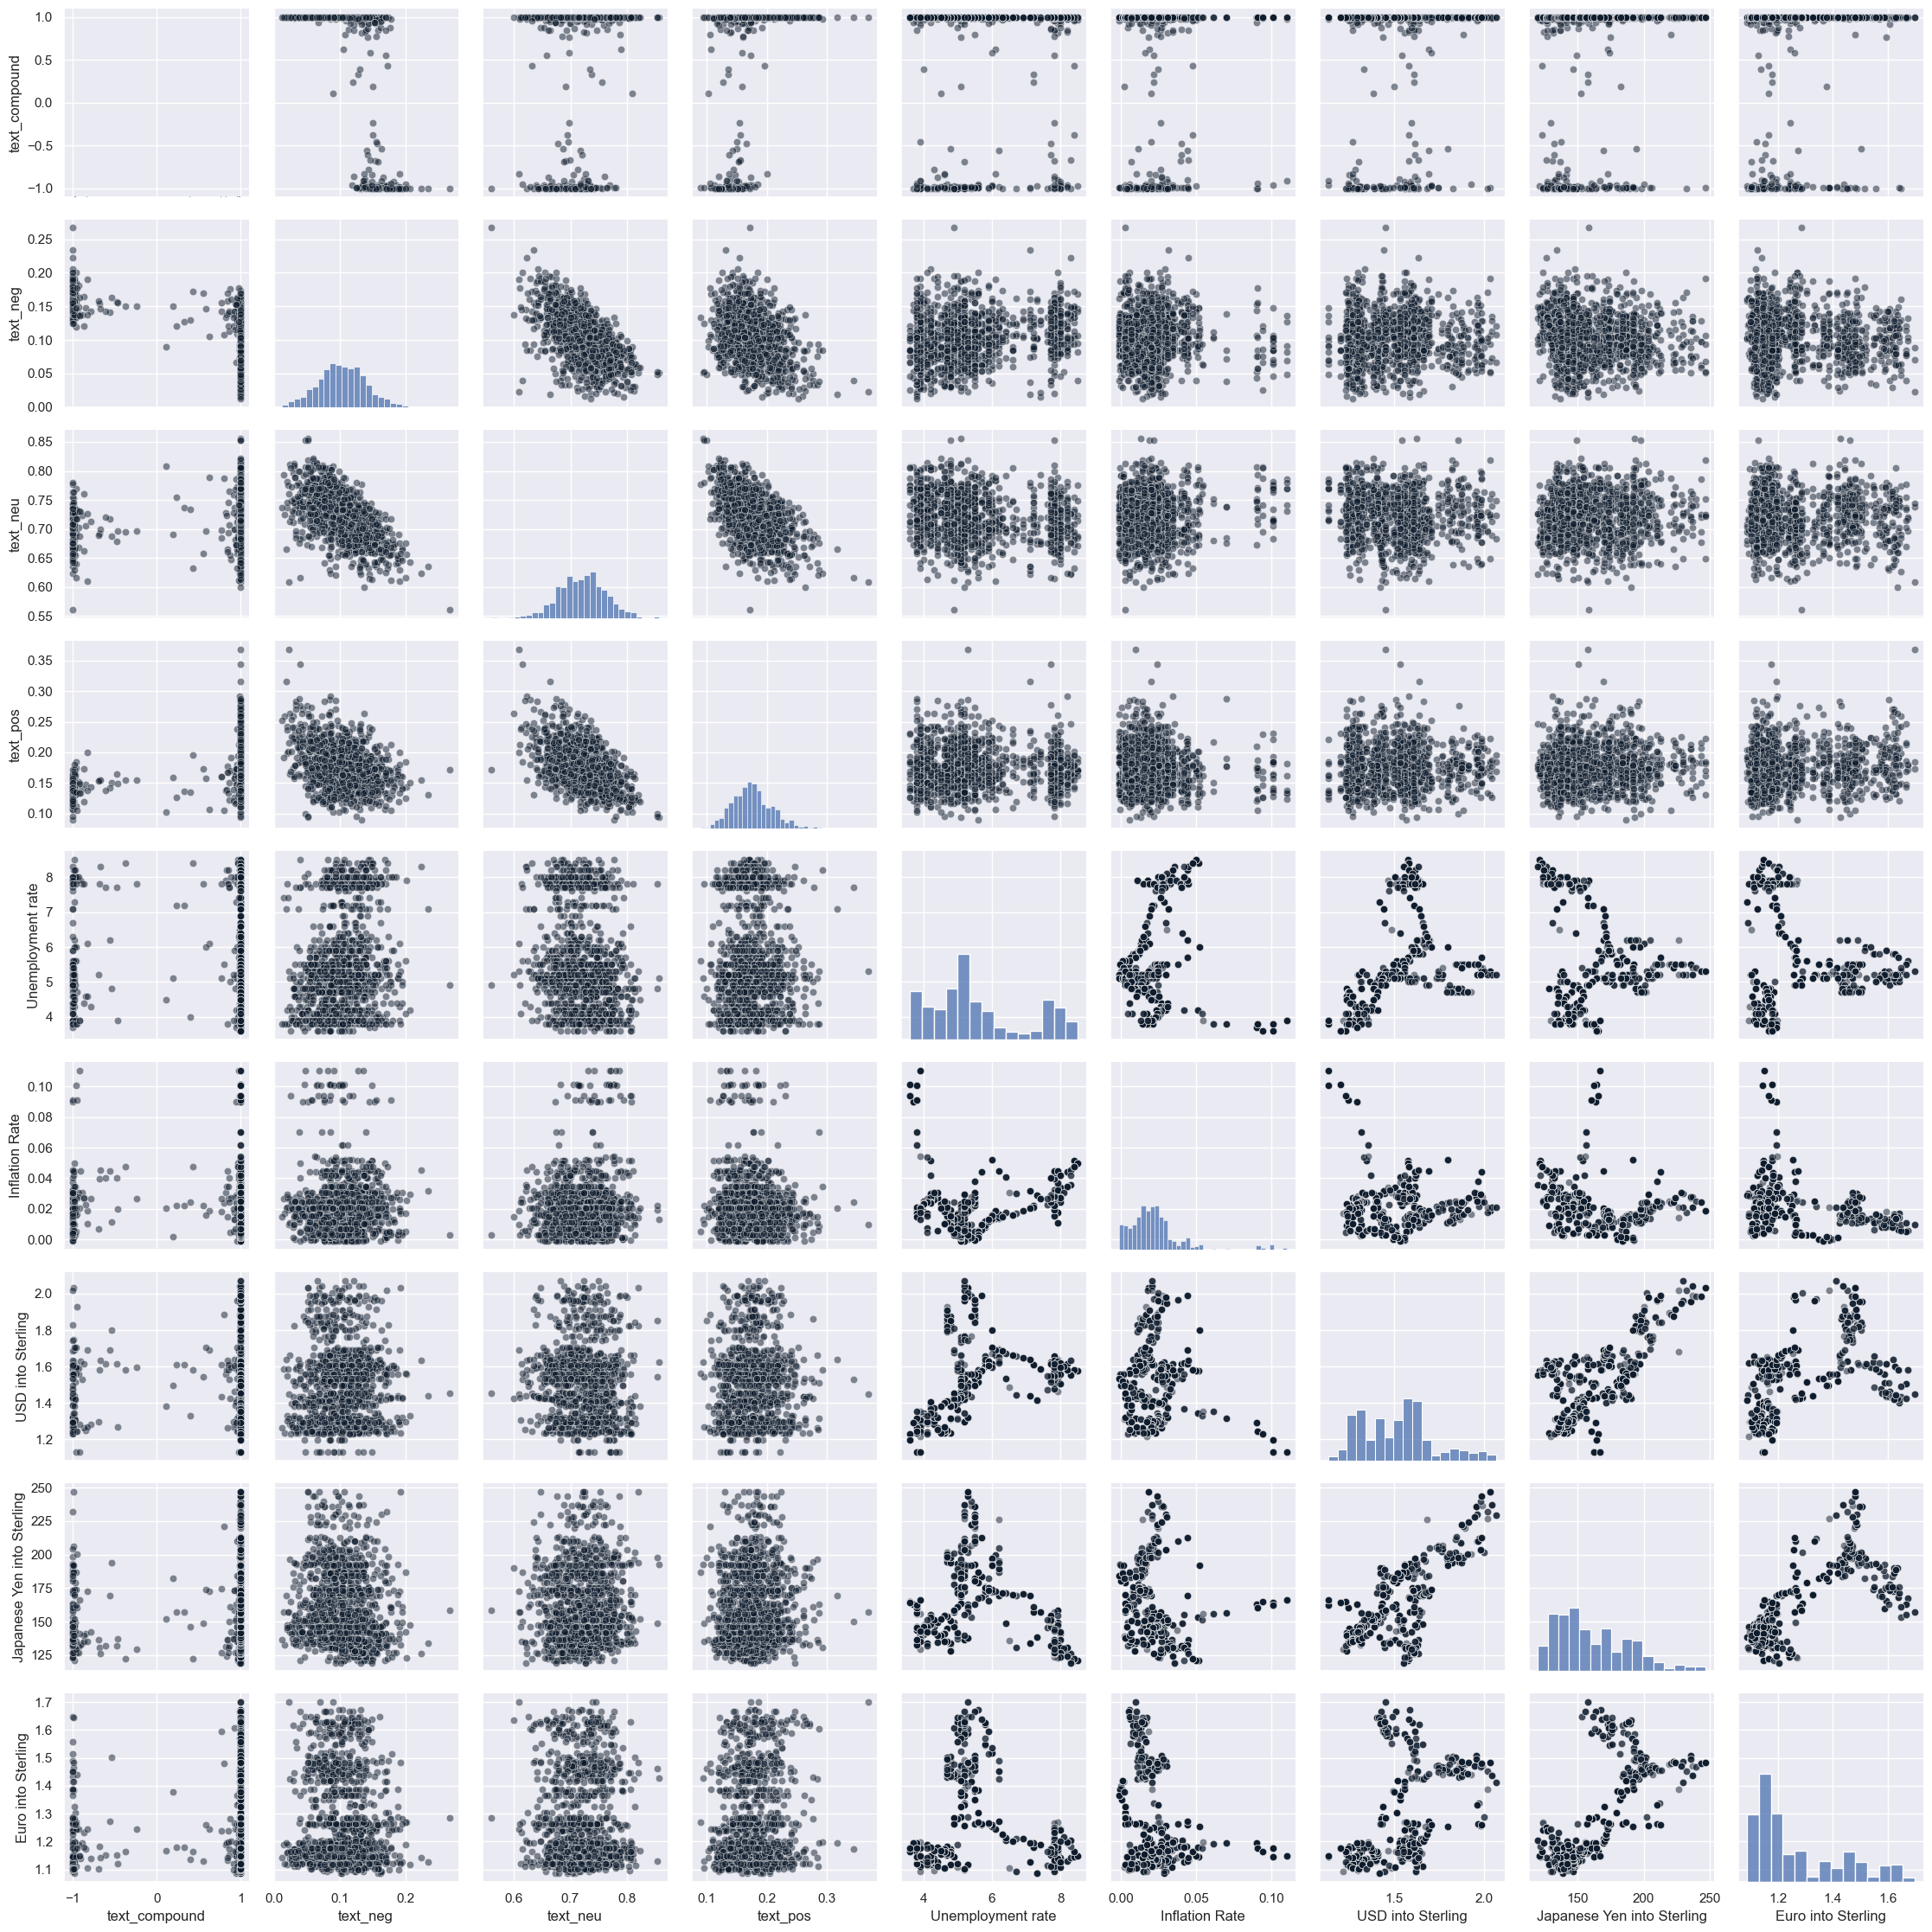

In [612]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_all = ['text_compound', 'text_neg', 'text_neu', 'text_pos', 'Unemployment rate', 'Inflation Rate', \
                     'USD into Sterling', 'Japanese Yen into Sterling', 'Euro into Sterling']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_vader_all], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [614]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader_all = boe_speeches_indicators[columns_vader_all].corr()

# Display the correlation matrix
correlation_matrix_vader_all

text_compound  text_neg  text_neu  text_pos  \
text_compound                    1.000000 -0.555258  0.192337  0.355214   
text_neg                        -0.555258  1.000000 -0.604002 -0.335403   
text_neu                         0.192337 -0.604002  1.000000 -0.548143   
text_pos                         0.355214 -0.335403 -0.548143  1.000000   
Unemployment rate               -0.038064  0.216422 -0.168690 -0.027661   
Inflation Rate                  -0.009871 -0.010799  0.102887 -0.110594   
USD into Sterling                0.068449  0.057734 -0.055413  0.005252   
Japanese Yen into Sterling       0.119718 -0.097532  0.044196  0.050011   
Euro into Sterling               0.096675 -0.064875 -0.021456  0.093603   

                            Unemployment rate  Inflation Rate  \
text_compound                       -0.038064       -0.009871   
text_neg                             0.216422       -0.010799   
text_neu                            -0.168690        0.102887   
text_pos                            -0.027661       -0.110594   
Unemployment rate                    1.000000        0.067503   
Inflation Rate                       0.067503        1.000000   
USD into Sterling                    0.433865       -0.118608   
Japanese Yen into Sterling          -0.243363       -0.177402   
Euro into Sterling                  -0.094911       -0.331445   

                            USD into Sterling  Japanese Yen into Sterling  \
text_compound                        0.068449                    0.119718   
text_neg                             0.057734                   -0.097532   
text_neu                            -0.055413                    0.044196   
text_pos                             0.005252                    0.050011   
Unemployment rate                    0.433865                   -0.243363   
Inflation Rate                      -0.118608                   -0.177402   
USD into Sterling                    1.000000                    0.660607   
Japanese Yen into Sterling           0.660607                    1.000000   
Euro into Sterling                   0.467030                    0.701887   

                            Euro into Sterling  
text_compound                         0.096675  
text_neg                             -0.064875  
text_neu                             -0.021456  
text_pos                              0.093603  
Unemployment rate                    -0.094911  
Inflation Rate                       -0.331445  
USD into Sterling                     0.467030  
Japanese Yen into Sterling            0.701887  
Euro into Sterling                    1.000000

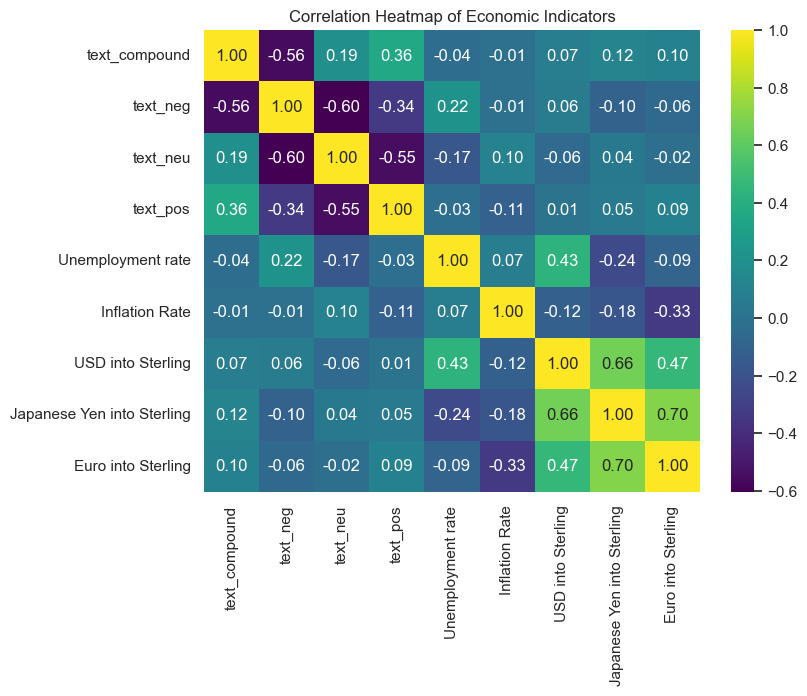

In [618]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader_all, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()